In [176]:
# импорт нужных библиотек
import os
from dotenv import load_dotenv
import requests as r
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import objects as so

In [177]:
load_dotenv()

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

current_dir = os.getcwd() 
charts_folder = os.path.join(current_dir, 'charts')

if not os.path.exists(charts_folder):
    os.makedirs(charts_folder)

In [178]:
#добавляем датафрейм с регистрациями
response_registrations = r.get(f"{API_URL}/registrations?begin={DATE_BEGIN}&end={DATE_END}")
json_data_registrations = response_registrations.json()
df_regs = pd.DataFrame(json_data_registrations)
df_regs

MissingSchema: Invalid URL 'None/registrations?begin=None&end=None': No scheme supplied. Perhaps you meant https://None/registrations?begin=None&end=None?

In [179]:
#добавляем датафрейм с посещениями
response_visits = r.get(f"{API_URL}/visits?begin={DATE_BEGIN}&end={DATE_END}")
json_data_visits = response_visits.json()
df_visits = pd.DataFrame(json_data_visits)
df_visits

MissingSchema: Invalid URL 'None/visits?begin=None&end=None': No scheme supplied. Perhaps you meant https://None/visits?begin=None&end=None?

## Шаг 3

In [124]:
#обрабатываем регистрации
filtered_regs = df_regs.drop(['email', 'registration_type'], axis=1)
filtered_regs.sort_values(['datetime', 'user_id'], inplace=True)
filtered_regs['datetime'] = pd.to_datetime(filtered_regs['datetime']).dt.date
#filtered_regs['date_group'] = pd.to_datetime(filtered_regs['date_group'], format='%Y-%m-%d')
#filtered_regs = filtered_regs.drop(['datetime'], axis=1)

filtered_regs = filtered_regs.groupby(['datetime', 'platform']).agg('count')
filtered_regs.columns = ['registrations']
filtered_regs

registrations
datetime   platform               
2023-03-01 android              61
           ios                  18
           web                   8
2023-03-02 android              59
           ios                  24
...                            ...
2023-08-30 ios                  40
           web                  34
2023-08-31 android              42
           ios                  36
           web                  46

[552 rows x 1 columns]

In [125]:
#обрабатываем посещения
filtered_visits = df_visits.drop(['user_agent'], axis=1)
filtered_visits = filtered_visits.drop(filtered_visits[filtered_visits['platform'] == 'bot'].index)
filtered_visits.sort_values(['datetime', 'visit_id'], inplace=True)

filtered_visits = filtered_visits.groupby(['visit_id', 'platform']).agg('max')
filtered_visits['datetime'] = pd.to_datetime(filtered_visits['datetime']).dt.date
#filtered_visits['date_group'] = pd.to_datetime(filtered_visits['date_group'], format='%Y-%m-%d')
#filtered_visits = filtered_visits.drop(['datetime'], axis=1)
filtered_visits = filtered_visits.reset_index()

filtered_visits = filtered_visits.groupby(['datetime', 'platform']).agg('count')
filtered_visits.columns = ['visits']
filtered_visits

visits
datetime   platform        
2023-03-01 android       75
           ios           22
           web          279
2023-03-02 android       67
           ios           31
...                     ...
2023-08-30 ios           66
           web         1227
2023-08-31 android       57
           ios           50
           web          721

[552 rows x 1 columns]

In [126]:
#объединяем датафреймы и считаем конверсию
conv_df = filtered_visits.join(
    filtered_regs,
    how='outer'
)
conv_df = conv_df.fillna(0)
conv_df['visits'] = conv_df['visits'].astype('int')
conv_df['registrations'] = conv_df['registrations'].astype('int')

conv_df['conversion'] = conv_df['registrations'] / conv_df['visits'] * 100
conv_df.replace([np.inf, -np.inf], 0, inplace=True)
conv_df = conv_df.reset_index()
conv_df

,datetime,platform,visits,registrations,conversion
0,2023-03-01,android,75,61,81.333333
1,2023-03-01,ios,22,18,81.818182
2,2023-03-01,web,279,8,2.867384
3,2023-03-02,android,67,59,88.059701
4,2023-03-02,ios,31,24,77.419355
...,...,...,...,...,...
547,2023-08-30,ios,66,40,60.606061
548,2023-08-30,web,1227,34,2.770986
549,2023-08-31,android,57,42,73.684211
550,2023-08-31,ios,50,36,72.000000


In [127]:
conv_df.to_json('conversion.json')

## Шаг 4

In [61]:
#добавляем датафрейм с рекламой
ads = pd.read_csv('ads.csv')
ads

,date,utm_source,utm_medium,utm_campaign,cost
0,2023-03-01T10:54:41,google,cpc,advanced_algorithms_series,212
1,2023-03-02T10:32:35,google,cpc,advanced_algorithms_series,252
2,2023-03-03T19:21:40,google,cpc,advanced_algorithms_series,202
3,2023-03-04T17:52:04,google,cpc,advanced_algorithms_series,223
4,2023-03-05T05:35:13,google,cpc,advanced_algorithms_series,265
...,...,...,...,...,...
154,2023-09-13T05:34:02,vk,social,intro_to_python_course,277
155,2023-09-14T18:25:13,vk,social,intro_to_python_course,221
156,2023-09-15T15:35:47,vk,social,intro_to_python_course,175
157,2023-09-16T05:30:26,vk,social,intro_to_python_course,224


In [62]:
#обрабатываем датафрейм с рекламой
filtered_ads = ads.drop(['utm_source', 'utm_medium'], axis=1)
filtered_ads.sort_values(['date'], inplace=True)
filtered_ads['date'] = pd.to_datetime(filtered_ads['date']).dt.date
filtered_ads.columns = ['datetime', 'utm_campaign', 'cost']
filtered_ads

,datetime,utm_campaign,cost
0,2023-03-01,advanced_algorithms_series,212
1,2023-03-02,advanced_algorithms_series,252
2,2023-03-03,advanced_algorithms_series,202
3,2023-03-04,advanced_algorithms_series,223
4,2023-03-05,advanced_algorithms_series,265
...,...,...,...
154,2023-09-13,intro_to_python_course,277
155,2023-09-14,intro_to_python_course,221
156,2023-09-15,intro_to_python_course,175
157,2023-09-16,intro_to_python_course,224


In [63]:
#создаем датафрейм без конверсии и аггрегации по платформам
vis_and_reg = conv_df.drop(['conversion'], axis=1)
vis_and_reg = vis_and_reg.groupby(['datetime']).agg(visits=('visits', 'sum'), registrations=('registrations', 'sum'))
vis_and_reg = vis_and_reg.reset_index()
vis_and_reg

,datetime,visits,registrations
0,2023-03-01,376,87
1,2023-03-02,613,106
2,2023-03-03,683,107
3,2023-03-04,647,159
4,2023-03-05,707,115
...,...,...,...
179,2023-08-27,795,88
180,2023-08-28,635,83
181,2023-08-29,1268,143
182,2023-08-30,1328,101


In [64]:
#объединяем данные о посещениях, регистрациях и рекламе
ads_df = pd.merge(
    vis_and_reg,
    filtered_ads,
    left_on='datetime',
    right_on='datetime',
    how='left'
)
ads_df['cost'] = ads_df['cost'].fillna(0)
ads_df

,datetime,visits,registrations,utm_campaign,cost
0,2023-03-01,376,87,advanced_algorithms_series,212.0
1,2023-03-02,613,106,advanced_algorithms_series,252.0
2,2023-03-03,683,107,advanced_algorithms_series,202.0
3,2023-03-04,647,159,advanced_algorithms_series,223.0
4,2023-03-05,707,115,advanced_algorithms_series,265.0
...,...,...,...,...,...
179,2023-08-27,795,88,intro_to_python_course,222.0
180,2023-08-28,635,83,intro_to_python_course,223.0
181,2023-08-29,1268,143,intro_to_python_course,190.0
182,2023-08-30,1328,101,intro_to_python_course,109.0


In [65]:
ads_df.to_json('ads.json')

## Шаг 5

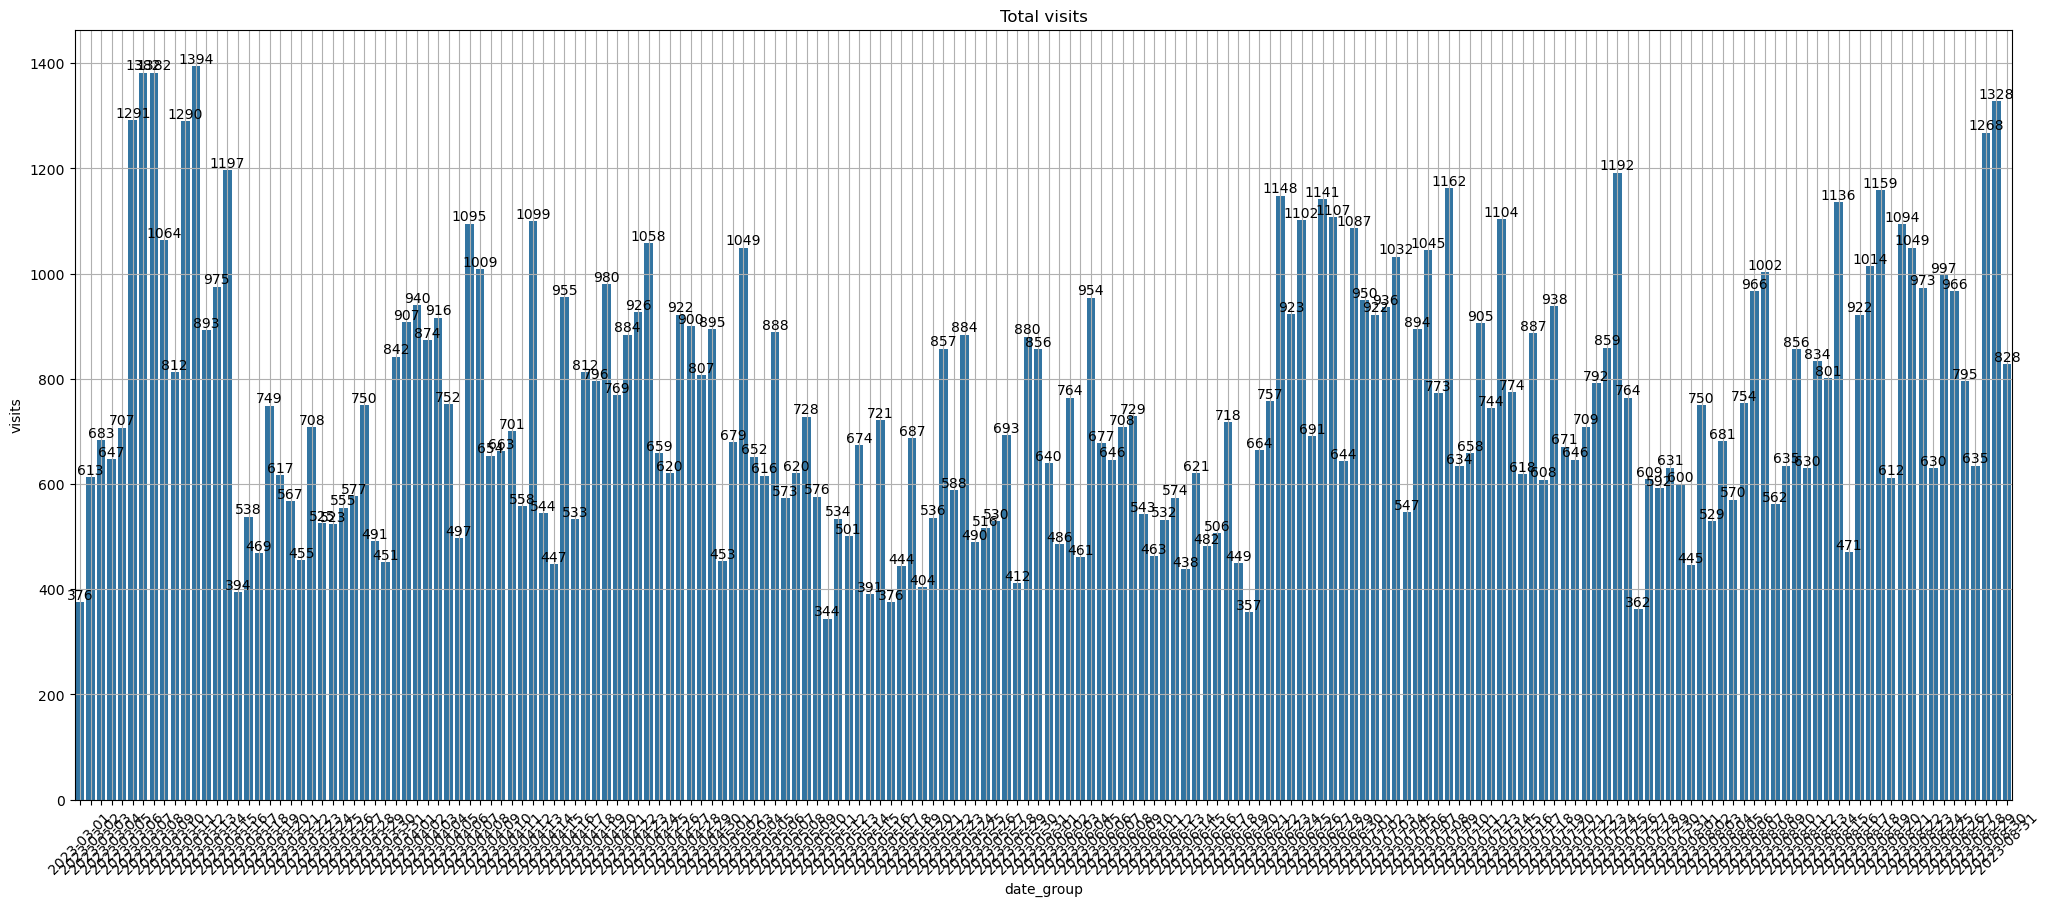

In [159]:
#1
plt.figure(figsize = (25, 10))

ax = sns.barplot(
    x='datetime',
    y='visits',
    data=ads_df
)
ax.bar_label(ax.containers[0])
plt.title('Total visits')
plt.xlabel('date_group')
plt.xticks(rotation=45)
plt.grid()

fig_total_visits.savefig('./charts/visits_by_date.png')
plt.show()

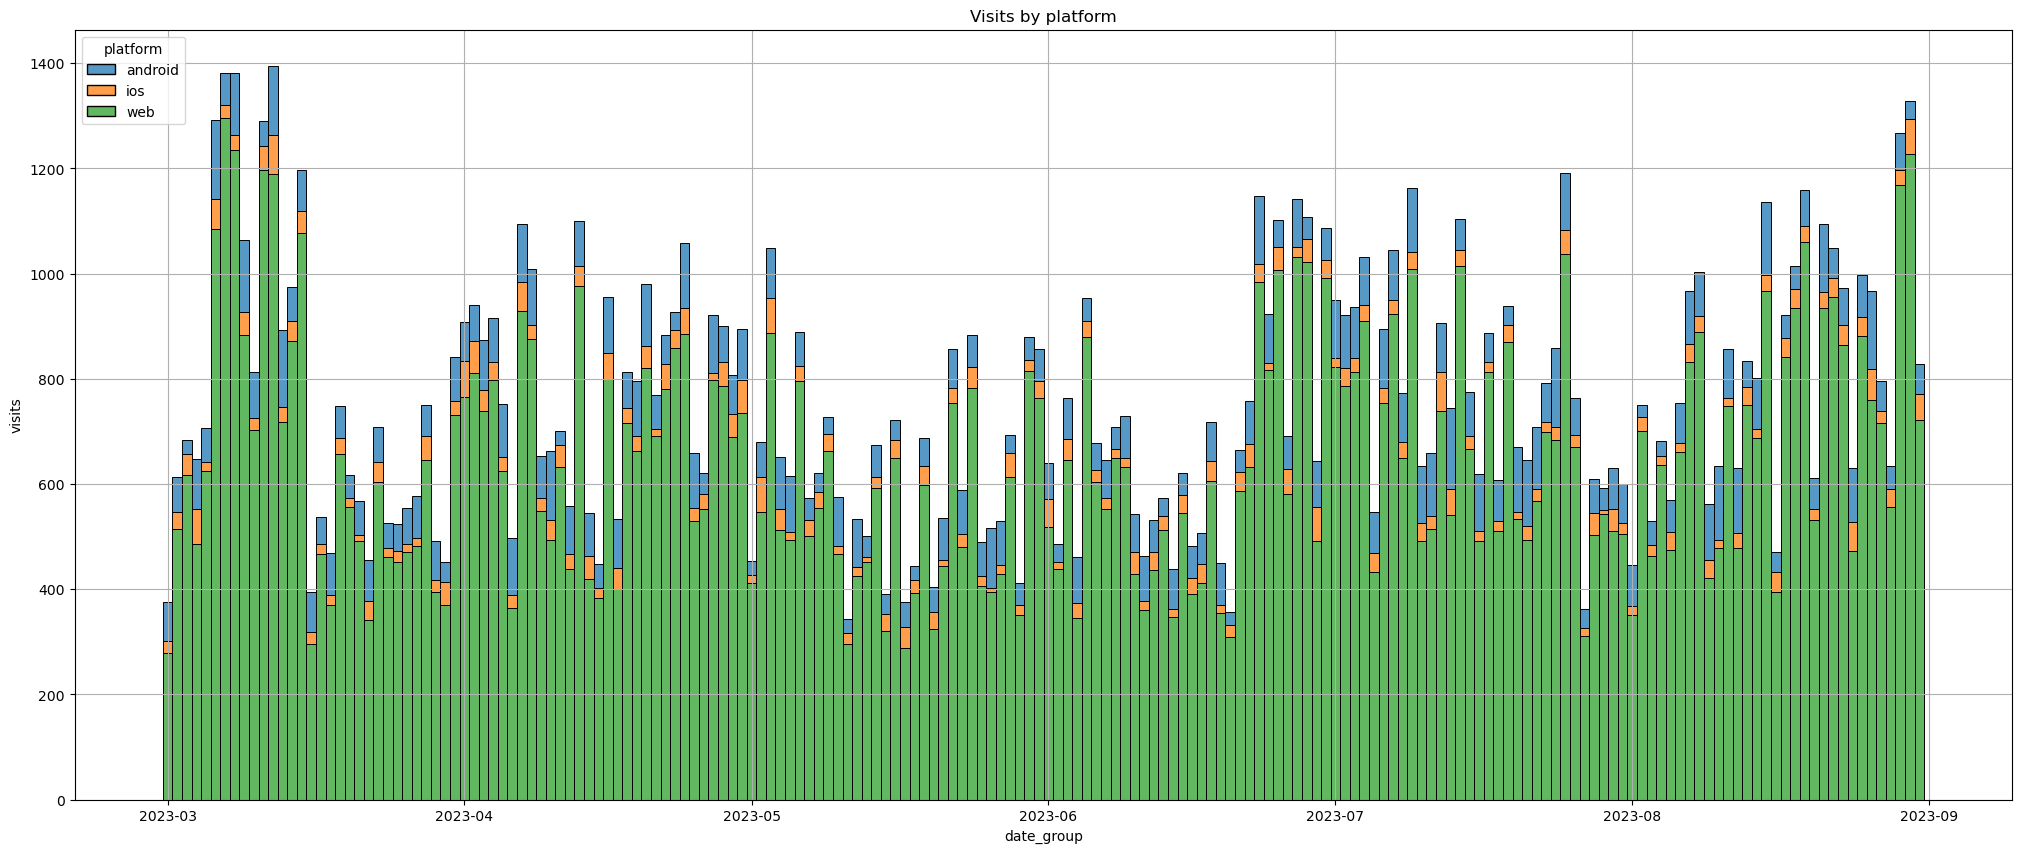

In [153]:
#2

plt.figure(figsize=(25, 10))

ax = sns.histplot(
    x='datetime',
    weights='visits',
    hue='platform',
    data=conv_df,
    multiple='stack'
)

plt.title('Visits by platform')
plt.xlabel('date_group')
plt.ylabel('visits')
plt.grid(True)

plt.savefig('./charts/visits_by_platform')
plt.show()

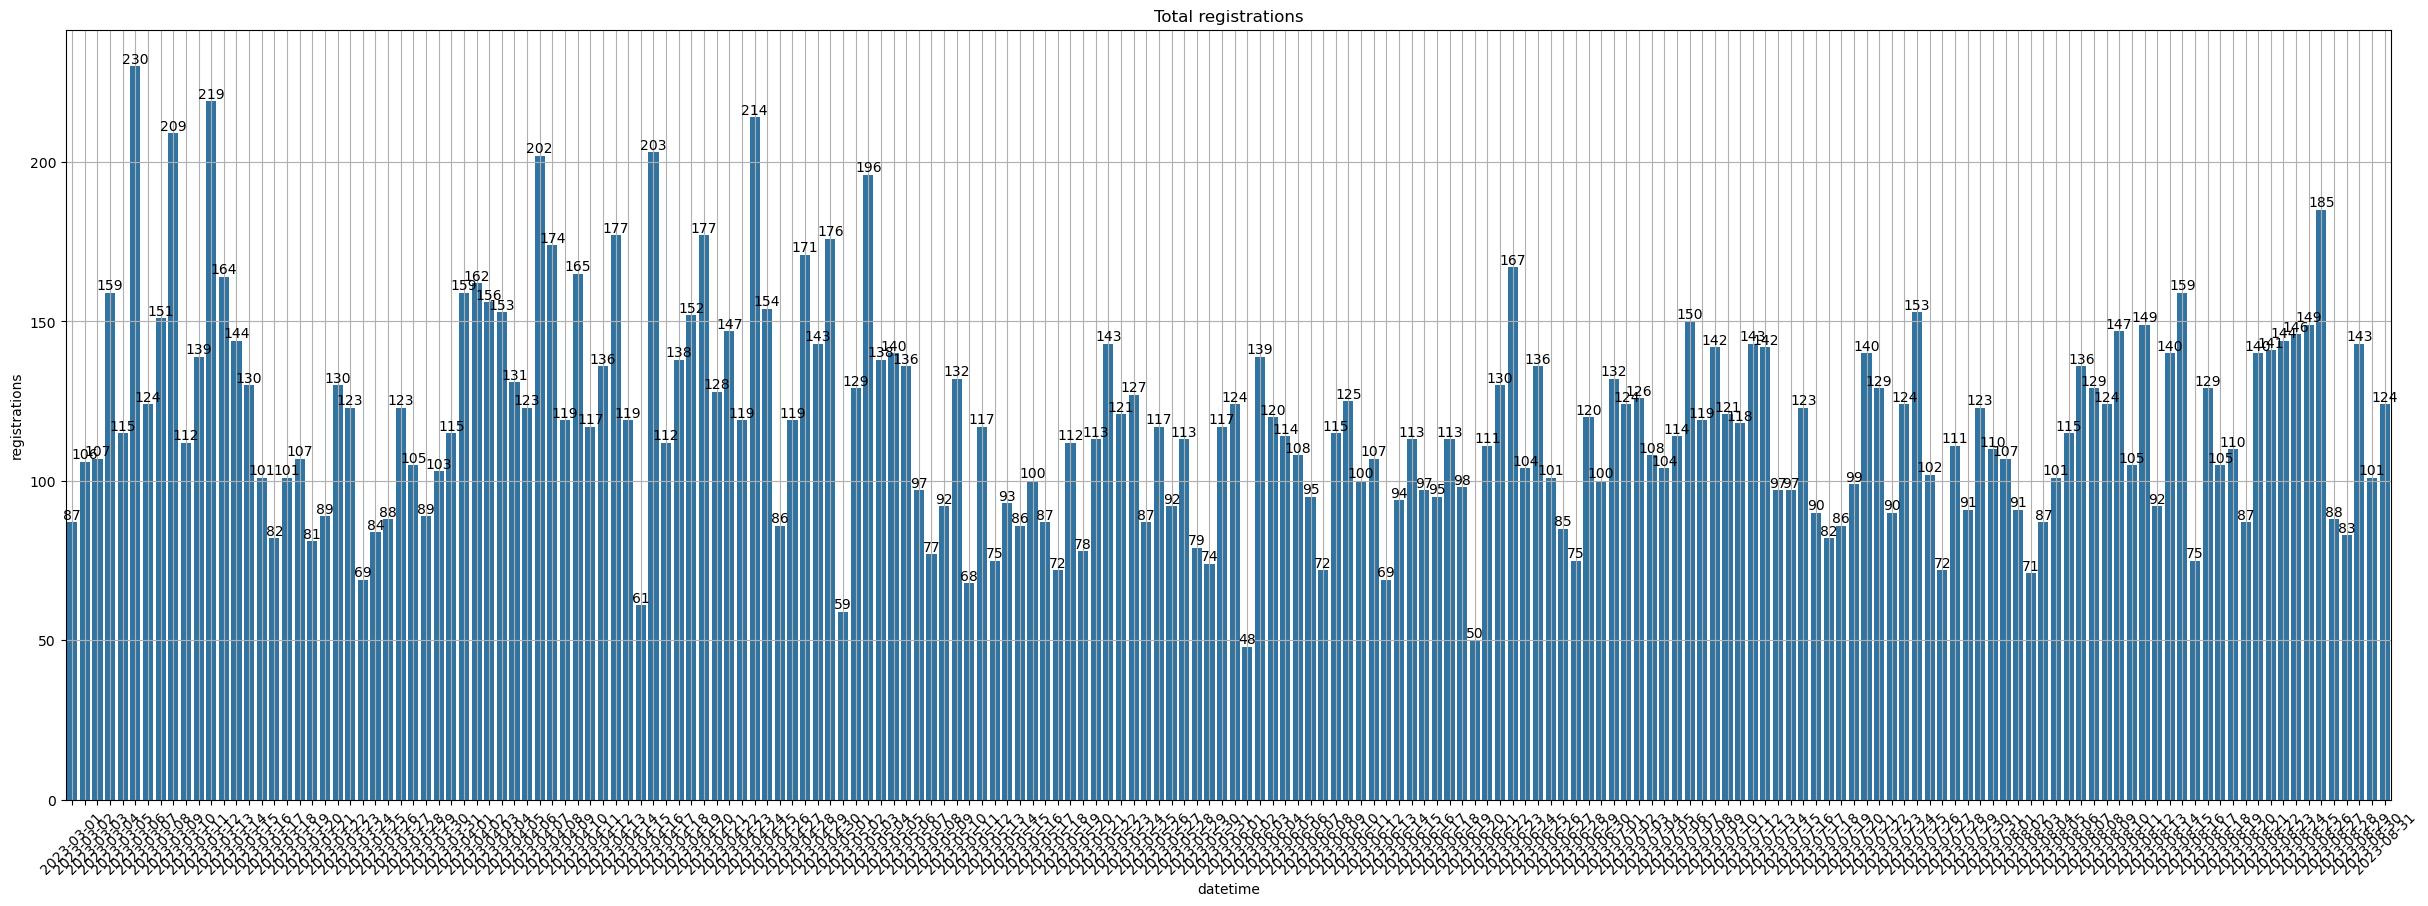

In [160]:
#3

plt.figure(figsize = (30, 10))

ax = sns.barplot(
    x = 'datetime',
    y = 'registrations',
    data=ads_df
)

ax.bar_label(ax.containers[0])
plt.title('Total registrations')
plt.xticks(rotation=45)
plt.grid()

plt.savefig('./charts/registrations_by_date')
plt.show()

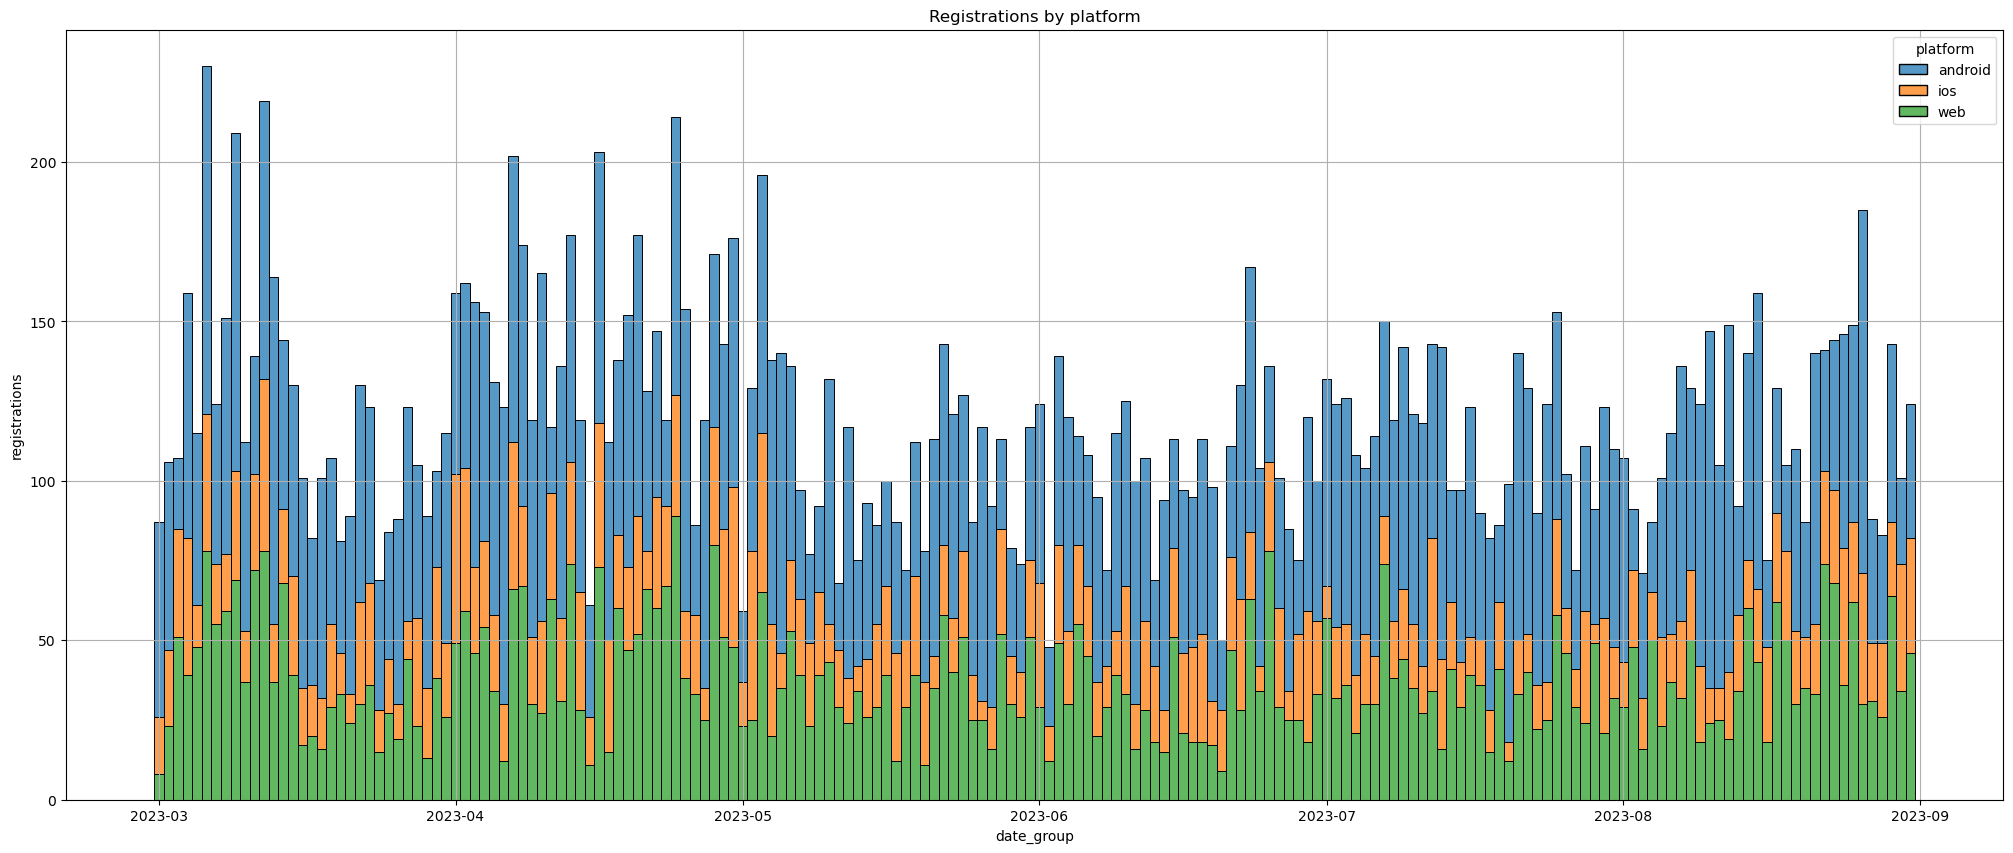

In [161]:
#4

fig, ax = plt.subplots(figsize=(25, 10))

ax = sns.histplot(
    x='datetime',
    weights='registrations',
    hue='platform',
    data=conv_df,
    multiple='stack'
)


plt.title('Registrations by platform')
plt.xlabel('date_group')
plt.ylabel('registrations')
plt.grid(True)

plt.savefig('./charts/registrations_by_platform')
plt.show()

In [162]:
#создаем датафрейм с общей конверсией
overall_conv = conv_df.drop(['platform', 'conversion'], axis=1)
overall_conv = overall_conv.groupby('datetime').agg(visits=('visits', 'sum'), registrations=('registrations', 'sum'))
overall_conv['conversion'] = round (overall_conv['registrations'] / overall_conv['visits'] * 100, 2)
overall_conv = overall_conv.drop(['visits', 'registrations'], axis=1)
overall_conv = overall_conv.reset_index()
overall_conv.columns = ['date_group', 'conversion']
overall_conv

,date_group,conversion
0,2023-03-01,23.14
1,2023-03-02,17.29
2,2023-03-03,15.67
3,2023-03-04,24.57
4,2023-03-05,16.27
...,...,...
179,2023-08-27,11.07
180,2023-08-28,13.07
181,2023-08-29,11.28
182,2023-08-30,7.61


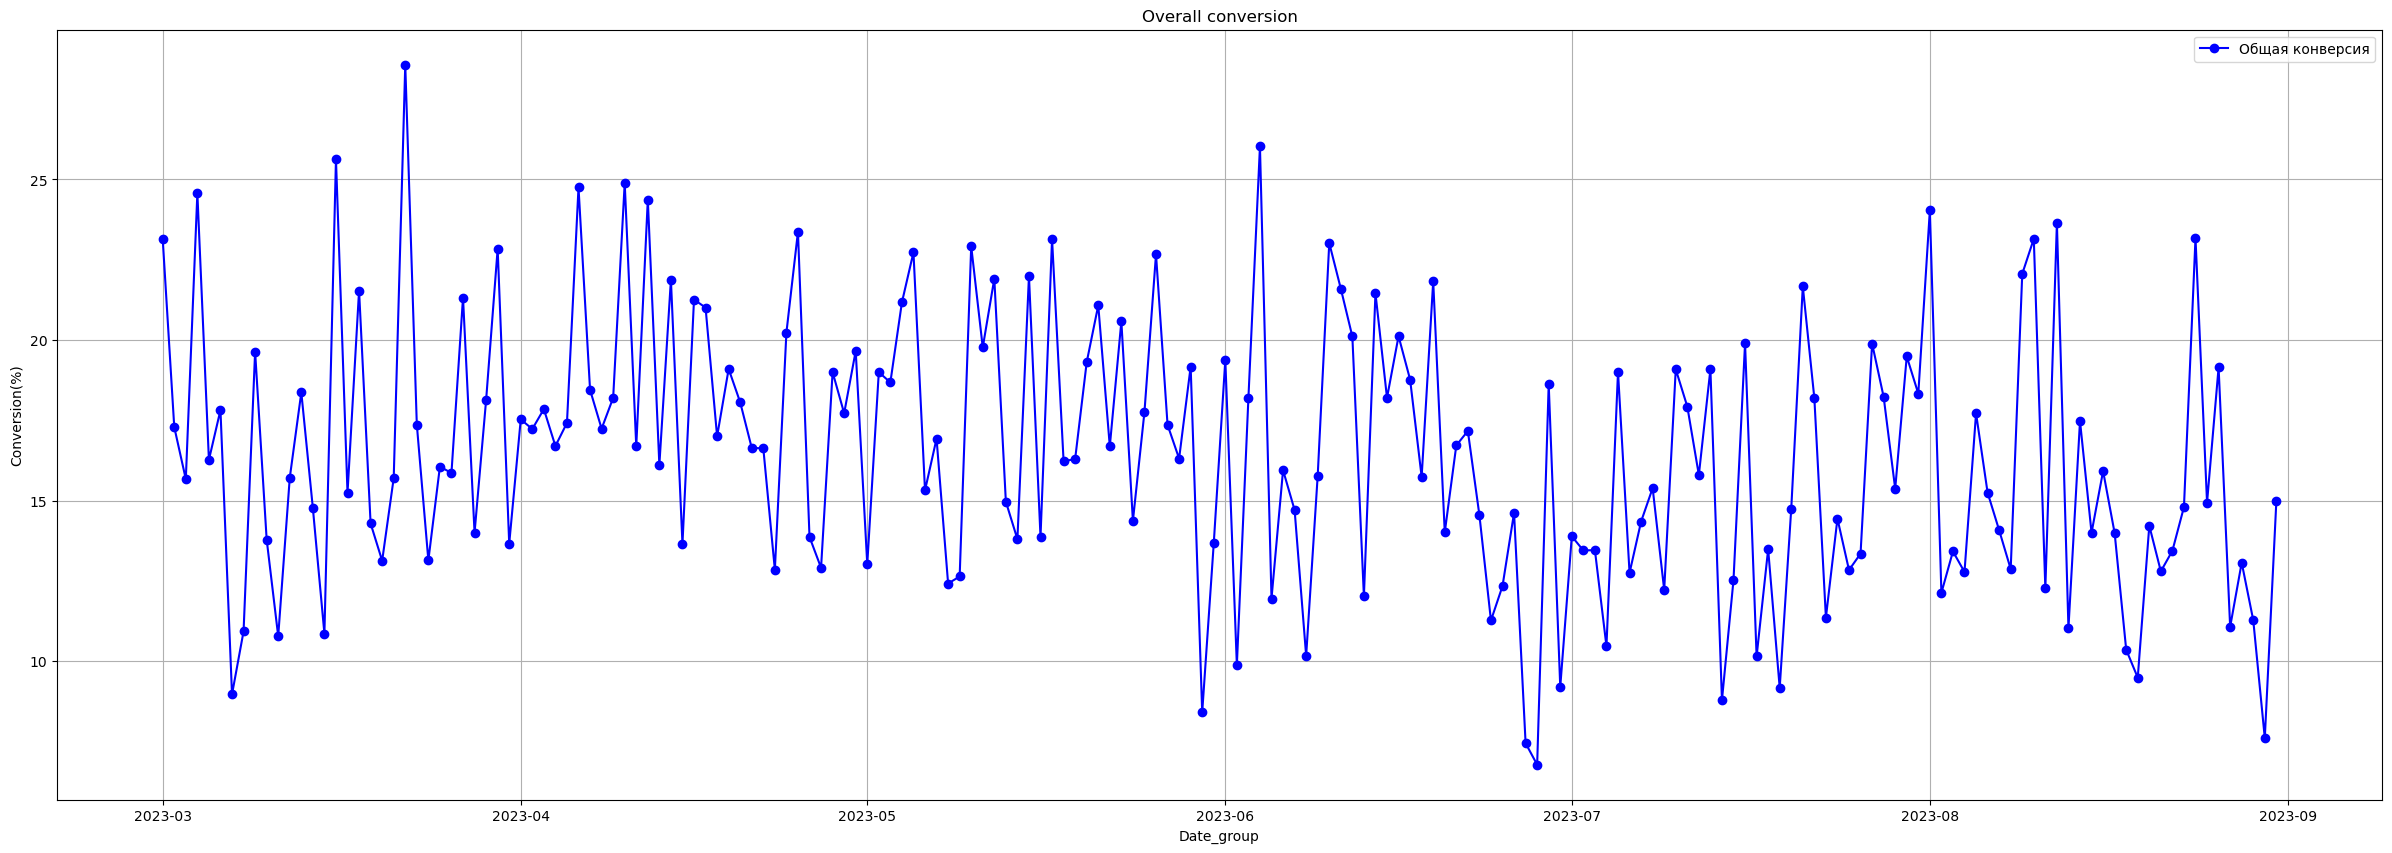

In [166]:
#5

plt.figure(figsize=(30, 10))

plt.plot(
    'date_group',
    'conversion',
    data=overall_conv,
    marker='o',
    color='blue',
    label='Общая конверсия'
)

plt.legend()
plt.title('Overall conversion')
plt.xlabel('Date_group')
plt.ylabel('Conversion(%)')
plt.grid(True)

plt.savefig('./charts/overall_conversion')
plt.show()

In [75]:
#создаем список платформ
platforms = conv_df['platform'].unique()
platforms

array(['android', 'ios', 'web'], dtype=object)

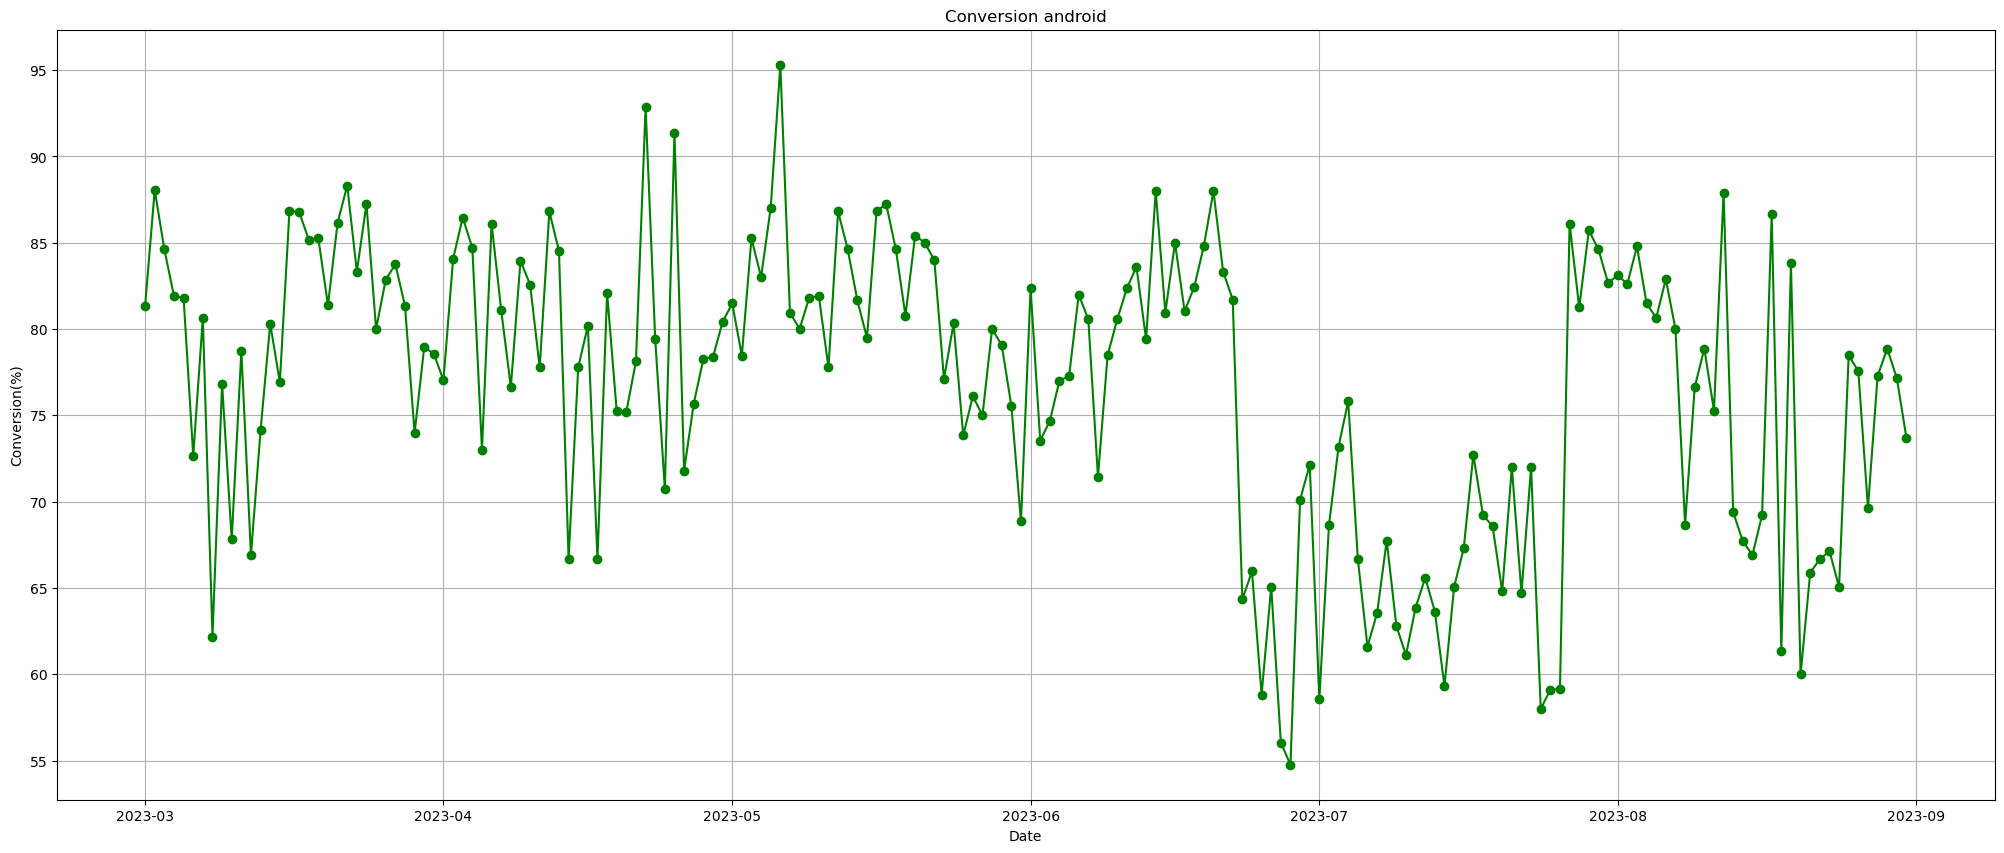

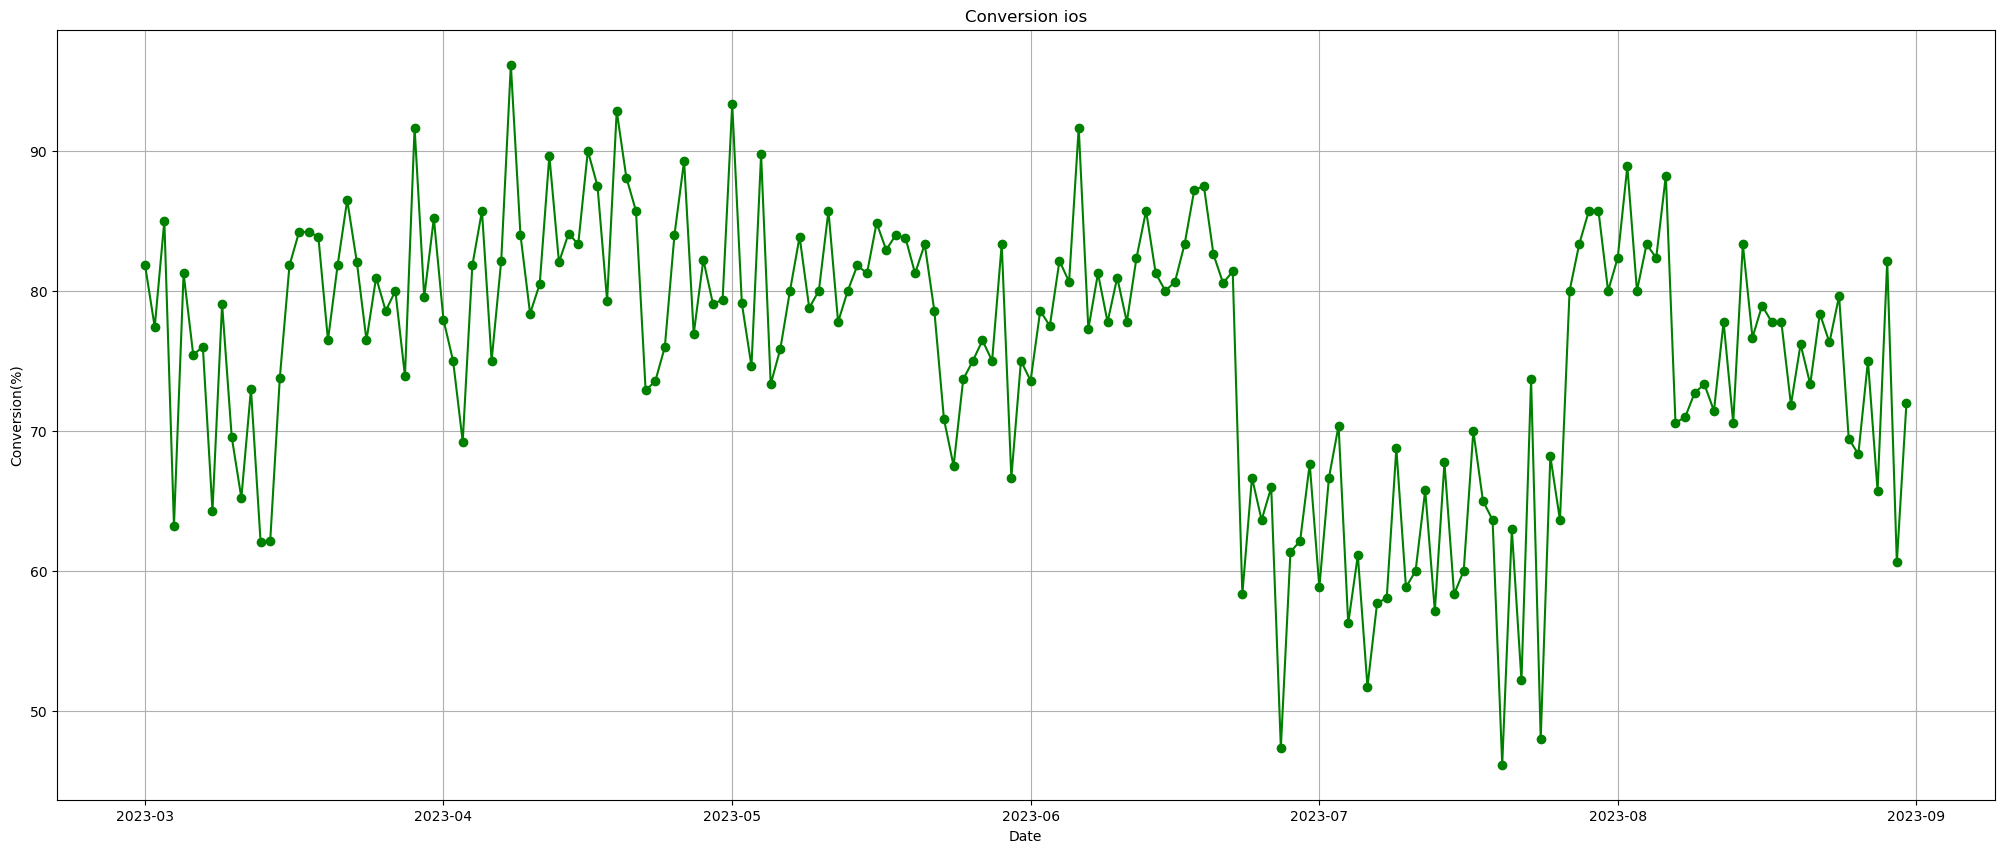

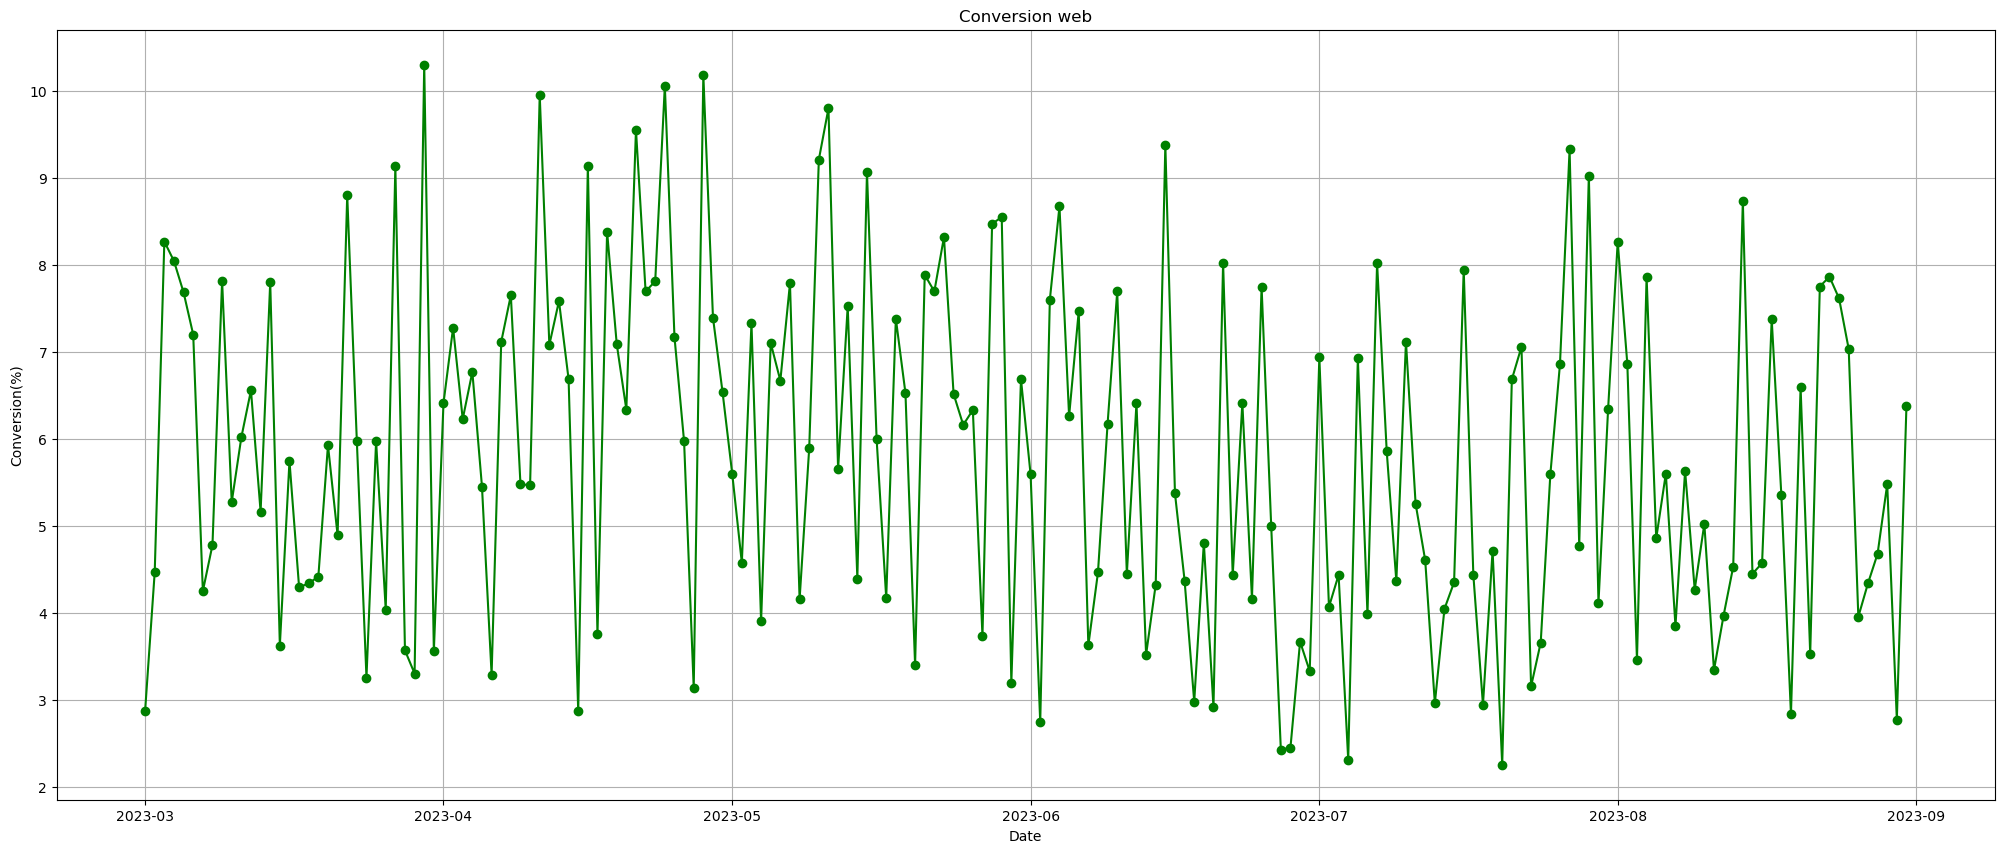

In [167]:
#6, 7, 8

for p in platforms:
    platform_conv = conv_df[conv_df['platform'] == p].drop(['platform', 'visits', 'registrations'], axis=1)
    plt.figure(figsize=(25, 10))

    plt.plot(
        'datetime',
        'conversion',
        data=platform_conv,
        color='green',
        marker='o'
    )

    plt.title(f'Conversion {p}')
    plt.xlabel('Date')
    plt.ylabel('Conversion(%)')
    plt.grid()

    plt.savefig(f'./charts/{p}_conversion')
    
plt.show()

In [163]:
#уберем лишние данные для графика
ads_by_day = ads_df.drop(['visits', 'registrations', 'utm_campaign'], axis=1)
ads_by_day

,datetime,cost
0,2023-03-01,212.0
1,2023-03-02,252.0
2,2023-03-03,202.0
3,2023-03-04,223.0
4,2023-03-05,265.0
...,...,...
179,2023-08-27,222.0
180,2023-08-28,223.0
181,2023-08-29,190.0
182,2023-08-30,109.0


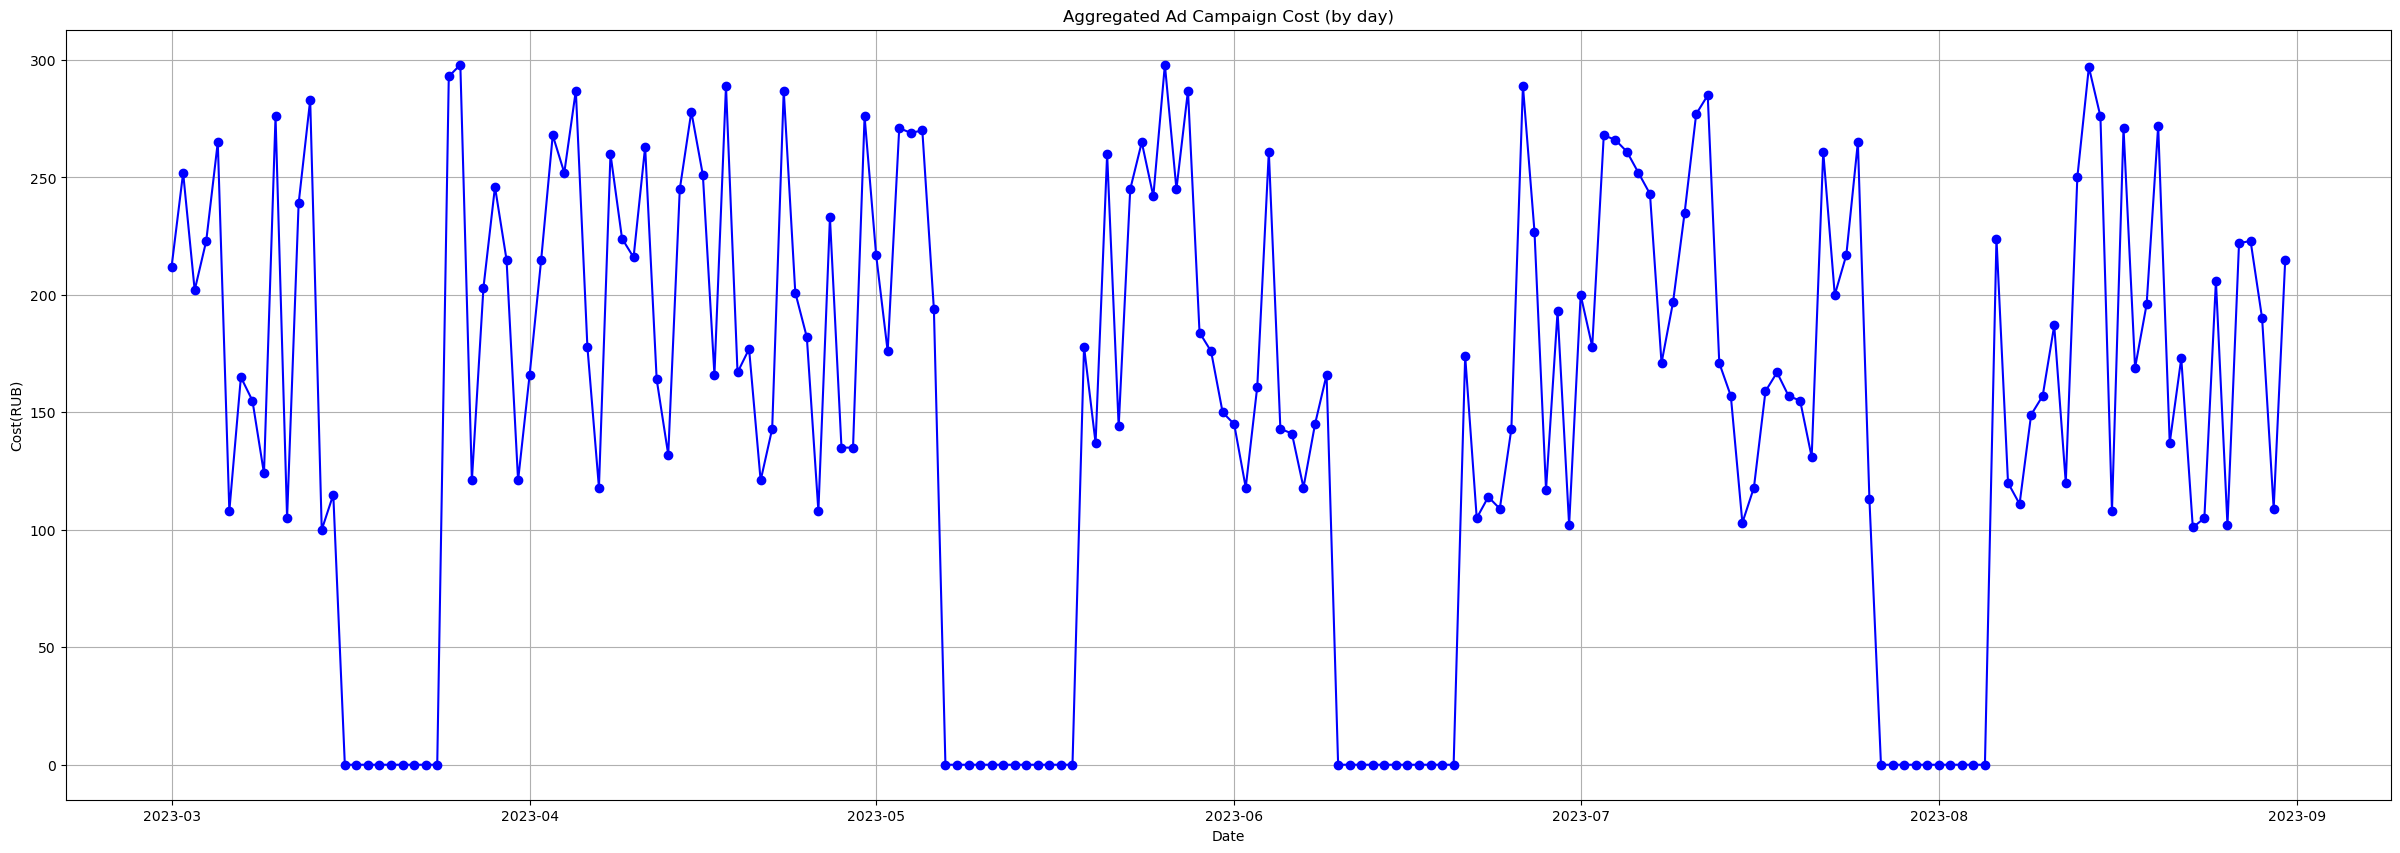

In [168]:
#9

plt.figure(figsize = (30, 10))

plt.plot(
    'datetime',
    'cost',
    data=ads_by_day,
    marker='o',
    color='blue'
)

plt.title('Aggregated Ad Campaign Cost (by day)')
plt.xlabel('Date')
plt.ylabel('Cost(RUB)')
plt.grid(True)

plt.savefig('./charts/ads_cost')
plt.show()

In [165]:
campaign_periods = ads_df.groupby(['utm_campaign']).agg(start = ('datetime', 'min'), end = ('datetime', 'max')).reset_index()
campaign_periods

,utm_campaign,start,end
0,advanced_algorithms_series,2023-03-01,2023-03-15
1,intro_to_python_course,2023-08-06,2023-08-31
2,ui_ux_design_drive,2023-05-19,2023-06-09
3,virtual_reality_workshop,2023-03-25,2023-05-06
4,women_in_tech_symposium,2023-06-21,2023-07-26


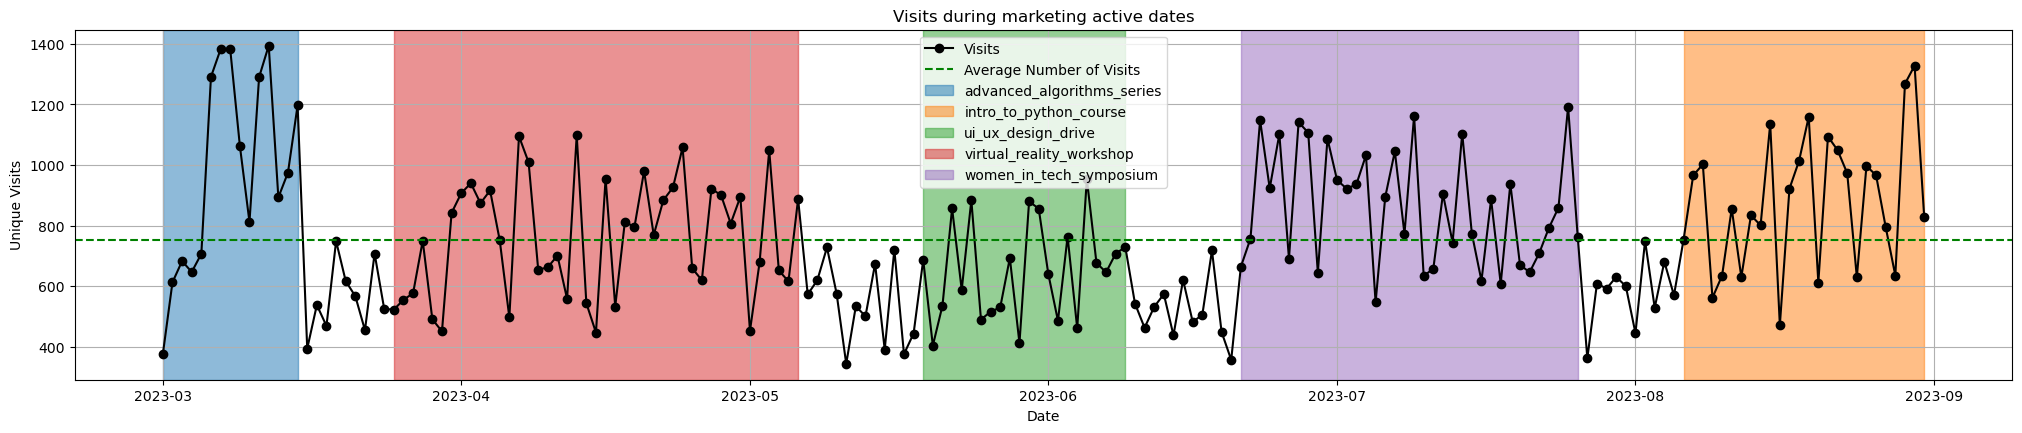

In [170]:
#10

plt.figure(figsize = (25, 10))

campaign_colors = dict(zip(campaign_periods['utm_campaign'].unique(), plt.cm.tab10.colors[:len(campaign_periods['utm_campaign'].unique())]))
plt.subplot(2, 1, 1)

plt.plot(ads_df['datetime'], ads_df['visits'], marker='o', color='black', label='Visits')
plt.axhline(y=np.nanmean(ads_df.visits), linestyle='dashed', color='green', label='Average Number of Visits')
for _,row in campaign_periods.iterrows():
    plt.axvspan(row['start'], row['end'], label=row['utm_campaign'], color=campaign_colors[row['utm_campaign']], alpha=0.5)
plt.title('Visits during marketing active dates')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Unique Visits')
plt.grid(True)

plt.savefig('./charts/ads_visits')
plt.show()

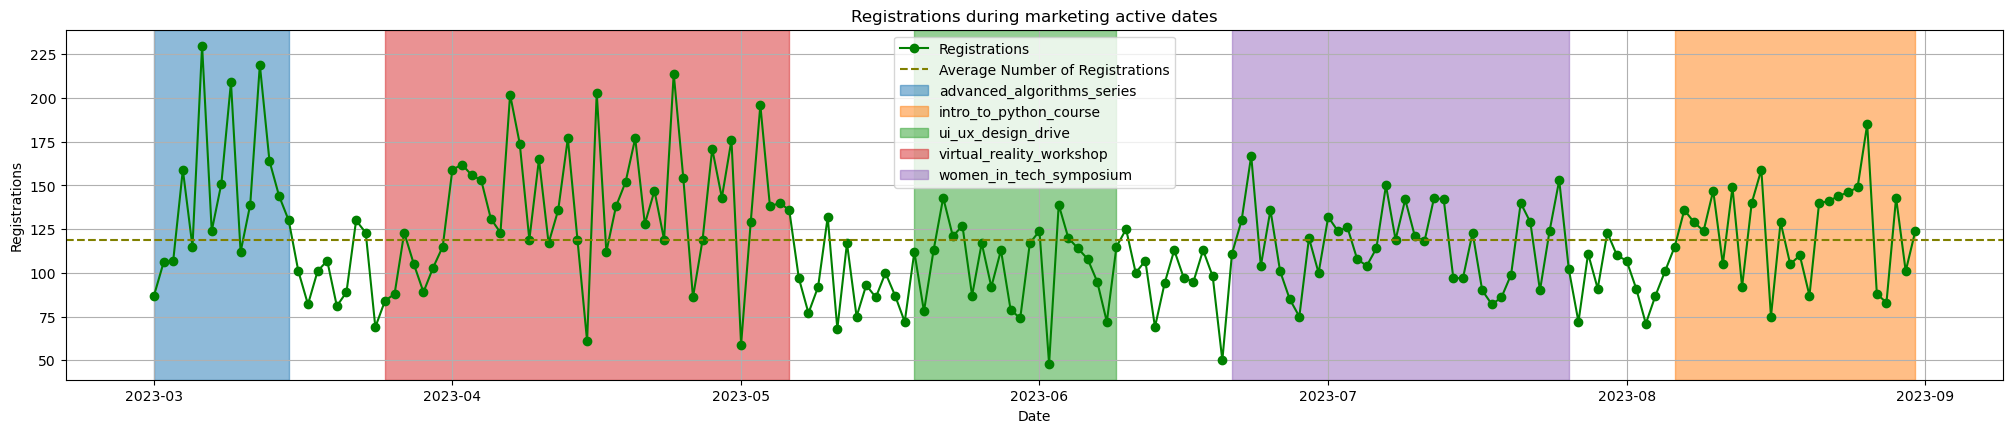

In [171]:
#11

plt.figure(figsize=(25,10))

campaign_colors = dict(zip(campaign_periods['utm_campaign'].unique(), plt.cm.tab10.colors[:len(campaign_periods['utm_campaign'].unique())]))
plt.subplot(2, 1, 1)

plt.plot(ads_df['datetime'], ads_df['registrations'], marker='o', color='green', label='Registrations')
plt.axhline(y=np.nanmean(ads_df.registrations), linestyle='dashed', color='olive', label='Average Number of Registrations')
for _,row in campaign_periods.iterrows():
    plt.axvspan(row['start'], row['end'], label=row['utm_campaign'], color=campaign_colors[row['utm_campaign']], alpha=0.5)
plt.title('Registrations during marketing active dates')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Registrations')
plt.grid(True)

plt.savefig('./charts/ads_registrations')
plt.show()